# CART: Classification and Regression Trees

<img src = 'images/louppe_2014_decision_tree.png' width = 80%>

Image source: Louppe, Gilles. Understanding random forests: From theory to practice. Diss. Universite de Liege (Belgium), 2014.

# Introduction and Dataset

## Background

This tutorial provides an example of how to apply classification and regression trees (CARTs), specifically random forest (RF) to model tree species. Here we will approach this challenge in two ways 1) classifying dominant tree species; and 2) regressing tree species proportions.

## Tutorial goals

**Goal 1: Develope a random forest (RF) classification model to classify dominant tree species**

**Goal 2: Perform feature selection using scikit-learn and remove correlated predictors**

**Goal 3: Train RF for tree species classification using five-fold cross validation**

**Goal 4: Experiment with different hyperparameters to limit overfitting**

**Goal 5: Create a new model that performs species proportion regression and compare to the species classification model.**

-----

## Data

This tutorial makes use of light detection and ranging (LiDAR) metrics and multispectral indices that are derived in the Lasso and Ridge Regression Tutorial notebook. Specifically, the `predictors.csv` file generated contains all the predictor variables used in the current tutorial. Please refer to the Lasso and Ridge Regression tutorial for more information about how these metrics/indices were calculated.

# Install and load packages

**Uncomment the cell below to install required packages**

In [172]:
# !pip install pandas==2.2.2
# !pip install geopandas==1.0.1
# !pip install matplotlib==3.10.1
# !pip install rioxarray==0.19.0
# !pip install spyndex==0.5.0
# !pip install pyarrow==19.0.0

In [173]:
import os
import pandas as pd
import seaborn as sns

# Download data

In [174]:
# Download the data if it does not yet exist
if not os.path.exists("data"):
  !gdown 1UDKAdXW0h6JSf7k31PZ-srrQ3487l9e2
  !unzip prf_data.zip -d data/
  os.remove("prf_data.zip")
else:
  print("Data has already been downloaded.")

os.listdir("data")

Data has already been downloaded.


['als_metrics.tif',
 'boundary.gpkg',
 'forest_point_cloud.las',
 'forest_point_cloud_footprint.gpkg',
 'original',
 'petawawa_s2_2018.tif',
 'petawawa_s2_2024.tif',
 'plots.gpkg',
 'predictors.csv',
 'trees.csv',
 'water.gpkg']

In [175]:
# Calculate dominant tree species based on biomass

predictors_df = pd.read_csv("data/predictors.csv")

trees_df = pd.read_csv("data/trees.csv")

predictors_df

,PlotName,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
0,PRF208R,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,0.637373,...,0.0,0.0,0.0,0.0,8.300000,0.0,0.0,1.170000,0.86,0.88
1,PRF320,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,0.565841,...,0.0,0.0,0.0,0.0,19.100000,8.0,2.2,6.650000,0.88,0.89
2,PRF016,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,0.658688,...,0.0,0.0,0.0,0.0,2.200000,3.4,11.8,5.000000,0.87,0.88
3,PRF017,0.832504,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,0.579135,...,0.0,0.0,0.0,0.0,9.599999,5.0,3.8,6.140000,0.83,0.84
4,PRF018,0.764120,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,0.541924,...,0.0,0.0,0.0,0.0,3.900000,2.7,2.9,6.980000,0.70,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,PRF183,0.857298,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,0.594032,...,9.7,2.7,1.5,0.1,1.100000,3.1,3.5,13.750000,0.94,0.95
235,PRF187,0.922648,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,0.733076,...,0.0,0.0,0.0,0.0,2.400000,4.2,3.4,9.820000,0.86,0.87
236,PRF209,0.829896,0.647397,0.315994,0.367099,0.462700,-0.693428,0.276003,0.527052,0.583441,...,0.0,0.0,0.0,0.0,2.200000,2.0,4.8,5.810000,0.83,0.86
237,PRF214,0.837961,0.559464,0.348880,0.410888,0.578021,-0.712261,0.303371,0.495551,0.532509,...,0.0,0.0,0.0,0.0,4.600000,5.1,5.5,9.929999,0.75,0.78


# Preprocessing

## Calculate dominant species in each plot based on biomass

In [176]:
# View the species composition across entire dataset by count
print(trees_df['species'].value_counts() / len(trees_df) * 100)

species
Balsam fir               14.694202
White pine               14.662431
Red (soft) maple         13.121525
Red pine                 10.961080
Jack pine                 4.741859
Red oak                   4.654488
White spruce              4.606831
Tamarack                  3.558380
Sugar Maple               3.510723
Trembling Aspen           3.161239
Ironwood                  1.969817
Norway Spruce             1.858618
American beech            1.858618
Black ash                 1.787133
White birch               1.739476
Largetooth aspen          1.556791
Yellow birch              0.992851
Basswood                  0.683082
Northern white cedar      0.468626
Eastern hemlock           0.373312
White ash                 0.182685
American elm              0.087371
Black cherry              0.087371
Balsam poplar             0.023828
Name: count, dtype: float64


In [177]:
# What can be said about the distribution of species? Describe species evenenss, richness, abundance, and overall diversity in this dataset.

# Tree Species Dominance

There are different ways of determining the dominant (i.e., leading) tree species in a given area. The simplest approach perhaps is to count the number of trees of a given species. However, this may not accurately represent dominance since one species may have many small trees that do not account for much volume or area.

Another approach is to calculate dominance based on volume or biomass. This means that a single massive tree may be dominant in a plot even if there are many more smaller trees.

Yet another approach is calculate dominance based on crown area or basal area. Crown area represents how much of the tree is seen from above (i.e., the crown). Basal area represents the area of the tree stem (i.e., trunk) at breast height.

In this tutorial, we will calculate dominance based on total tree volume. This is represented by the `tvol` column in the `trees.csv` dataset.

In [ ]:
# Lets examine the distribution of species in the dataset
sp_dom_agg = trees_df.groupby('species').agg(
    sp_count=('dom_sp', 'count')).sort_values(by='sp_count', ascending=False)

In [178]:
trees_df

,PlotName,TreeID,species,Origin,Status,DBH,CrownClass,DecayClass,height,baha,codom,mvol,tvol,biomass,size
0,PRF001,24.0,White pine,P,D,10.1,NaN,1.0,11.552521,0.128190,N,0.000000,0.708735,393.396400,Poles
1,PRF001,46.0,White pine,P,D,9.9,NaN,2.0,11.422529,0.123163,N,0.000000,0.673254,375.305379,Poles
2,PRF001,20.0,Red pine,N,L,67.5,D,NaN,33.900000,5.725566,Y,77.327438,79.482658,39691.639950,Large
3,PRF001,50.0,Red pine,N,L,57.9,D,NaN,32.528851,4.212773,Y,56.444281,58.117292,28251.255888,Large
4,PRF001,10.0,White pine,N,L,55.9,D,NaN,33.000000,3.926761,Y,48.008649,49.833743,24501.838779,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12585,PRF334,NaN,Sugar Maple,N,L,3.7,NaN,NaN,8.893640,0.215043,N,0.000000,0.858564,851.191939,Under
12586,PRF334,NaN,Sugar Maple,N,L,3.3,NaN,NaN,8.500000,0.171060,N,0.000000,0.653868,659.084439,Under
12587,PRF334,NaN,Sugar Maple,N,L,3.2,NaN,NaN,8.395967,0.160850,N,0.000000,0.607493,615.333049,Under
12588,PRF334,NaN,Sugar Maple,N,L,3.0,NaN,NaN,7.400000,0.141372,N,0.000000,0.469656,521.064025,Under


In [179]:
trees_df['tvol']

0         0.708735
1         0.673254
2        79.482658
3        58.117292
4        49.833743
           ...    
12585     0.858564
12586     0.653868
12587     0.607493
12588     0.469656
12589     0.404460
Name: tvol, Length: 12590, dtype: float64

In [180]:
# Assign a new, unique ID for each tree
trees_df['tree_id'] = trees_df.index + 1

In [181]:
# Calculate tree dominance based on stem count (i.e., proportion of occurence in plot)


def calc_sp_freq(trees):

    sp_agg = trees.groupby('species').agg(sp_tvol=('tvol', 'sum'),)

    sp_agg['sp_vol_prop'] = sp_agg['sp_tvol'] / trees['tvol'].sum()

    # Sort in descending order by total volume
    sp_agg = sp_agg.sort_values(by='sp_tvol', ascending=False).reset_index()

    # Get the first row
    if len(sp_agg) == 0:
        print(f"No trees in plot: {trees['PlotName'].iloc[0]}")
        dom_sp = None        
    else:
        dom_sp = sp_agg['species'].iloc[0]
    
    return(dom_sp)


for plot_nm in plots_gdf['PlotName']:

    print(f"Processing plot: {plot_nm}")

    trees_i = trees_df[trees_df['PlotName'] == plot_nm]

    dom_sp = calc_sp_freq(trees_i)

    plots_gdf.loc[plots_gdf['PlotName'] == plot_nm, 'dom_sp'] = dom_sp

Processing plot: PRF208R
Processing plot: PRF320
Processing plot: PRF016
Processing plot: PRF017
Processing plot: PRF018
Processing plot: PRF019
Processing plot: PRF020
Processing plot: PRF021
Processing plot: PRF044
Processing plot: PRF068
Processing plot: PRF070
Processing plot: PRF075
Processing plot: PRF084
Processing plot: PRF135
Processing plot: PRF159
Processing plot: PRF169
Processing plot: PRF311
Processing plot: PRF318
Processing plot: PRF319
Processing plot: PRF321
Processing plot: PRF322
Processing plot: PRF323
Processing plot: PRF324
Processing plot: PRF326
Processing plot: PRF010
Processing plot: PRF014
Processing plot: PRF015
Processing plot: PRF022
Processing plot: PRF023
Processing plot: PRF024
Processing plot: PRF025
Processing plot: PRF026
Processing plot: PRF030
Processing plot: PRF031
Processing plot: PRF045
Processing plot: PRF052
Processing plot: PRF066
Processing plot: PRF079
Processing plot: PRF080
Processing plot: PRF082
Processing plot: PRF083
Processing plot

In [182]:
# Remove plots which don't have trees
plots_gdf = plots_gdf[~plots_gdf['dom_sp'].isna()]

# View distribution of dominant species
sp_dom_agg = plots_gdf.groupby('dom_sp').agg(
    sp_count=('dom_sp', 'count')).sort_values(by='sp_count', ascending=False)

sp_dom_agg['sp_prop'] = sp_dom_agg['sp_count'] / len(plots_gdf) * 100

sp_dom_agg = round(sp_dom_agg, 1)

print(sp_dom_agg)

                       sp_count  sp_prop
dom_sp                                  
White pine                   89     36.8
Red pine                     34     14.0
Red oak                      19      7.9
Tamarack                     18      7.4
Jack pine                    14      5.8
Trembling Aspen              11      4.5
Sugar Maple                  11      4.5
White spruce                 10      4.1
Largetooth aspen              9      3.7
Red (soft) maple              9      3.7
Balsam fir                    8      3.3
American beech                4      1.7
Northern white cedar          3      1.2
Black ash                     3      1.2


In [183]:
# Since some species are only dominant in one or two plots, we will remove these from the dataset to simplify the analysis

# Note that there are other ways of dealing with outliers such as this, but for the sake of simplicity we will just remove them

rare_species = sp_dom_agg[sp_dom_agg['sp_prop'] < 1].index.tolist()

print(f"Removing {len(rare_species)} rare species: {rare_species}")

plots_gdf = plots_gdf[~plots_gdf['dom_sp'].isin(rare_species)]

plots_gdf


Removing 0 rare species: []


,PlotName,Date,Northing,Easting,Source,geometry,dom_sp,dom_sp_id
0,PRF208R,August 7 2018,5098426.096,312924.933,Topcon Hiper V PPP,POINT Z (312924.734 5098427.112 0),White pine,12
1,PRF320,November 23 2018,5098579.361,312625.094,Topcon HiperSR PPP,POINT Z (312624.895 5098580.377 0),Jack pine,3
2,PRF016,August 8 2018,5096992.483,313662.119,Topcon Hiper V PPP,POINT Z (313661.921 5096993.499 0),White pine,12
3,PRF017,August 14 2018,5096896.098,313863.850,Topcon Hiper V PPP,POINT Z (313863.652 5096897.114 0),Jack pine,3
4,PRF018,August 8 2018,5097138.299,313692.563,Topcon Hiper V PPP,POINT Z (313692.365 5097139.315 0),Jack pine,3
...,...,...,...,...,...,...,...,...
243,PRF183,November 4 2018,5091453.546,301823.319,Topcon Hiper V PPP,POINT Z (301823.119 5091454.56 0),White pine,12
244,PRF187,November 22 2018,5091476.078,308950.650,Topcon Hiper V PPP,POINT Z (308950.451 5091477.093 0),Largetooth aspen,4
246,PRF214,October 6 2018,5091627.257,312973.063,Topcon Hiper V PPP,POINT Z (312972.865 5091628.272 0),White pine,12
247,PRF149,October 25 2018,5090277.081,301422.935,Topcon HiperSR PPP,POINT Z (301422.735 5090278.095 0),Red pine,8


In [184]:
# Assign nummieric IDs to each dominant species
plots_gdf['dom_sp_id'] = plots_gdf['dom_sp'].astype('category').cat.codes

# Create a dictionary mapping species names to their IDs
dom_sp_dict = plots_gdf[['dom_sp', 'dom_sp_id']].drop_duplicates().sort_values(by='dom_sp_id').set_index('dom_sp_id', drop=True).to_dict()['dom_sp']

dom_sp_dict

{0: 'American beech ',
 1: 'Balsam fir ',
 2: 'Black ash ',
 3: 'Jack pine ',
 4: 'Largetooth aspen ',
 5: 'Northern white cedar ',
 6: 'Red (soft) maple ',
 7: 'Red oak ',
 8: 'Red pine ',
 9: 'Sugar Maple ',
 10: 'Tamarack ',
 11: 'Trembling Aspen ',
 12: 'White pine ',
 13: 'White spruce '}

In [185]:
# Extract predictor var list
features_ls = predictors_df.drop("PlotName", axis=1).columns.tolist()

print("Predictor variables:")
print("\n".join(features_ls))

# Join the dominant species IDs to the predictors dataframe
df = plots_gdf[['PlotName', 'dom_sp_id']].merge(predictors_df, on='PlotName', how='left')

df

Predictor variables:
NDVI
NBR
SAVI
MSAVI
DSI
NDWI
GLI
ND705
NDREI
IRECI
TGI
avg_95
avg
b10
b20
b30
b40
b50
b60
b70
b80
b90
dns_10m
dns_12m
dns_14m
dns_15m
dns_16m
dns_18m
dns_20m
dns_25m
dns_2m
dns_4m
dns_5m
dns_6m
dns_8m
kur_95
p01
p05
p10
p20
p30
p40
p50
p60
p70
p80
p90
p95
p99
qav
skew_95
d0_2
d10_12
d12_14
d14_16
d16_18
d18_20
d20_22
d22_24
d24_26
d26_28
d28_30
d2_4
d30_32
d32_34
d34_36
d36_38
d38_40
d40_42
d42_44
d44_46
d46_48
d4_6
d6_8
d8_10
std_95
vci_1mbin
vci_0.5bin


,PlotName,dom_sp_id,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
0,PRF208R,12,0.880349,0.709994,0.488931,0.606115,0.387605,-0.750999,0.364300,0.547740,...,0.0,0.0,0.0,0.0,8.300000,0.0,0.0,1.170000,0.86,0.88
1,PRF320,3,0.824918,0.540868,0.356151,0.419385,0.590963,-0.709425,0.278922,0.500269,...,0.0,0.0,0.0,0.0,19.100000,8.0,2.2,6.650000,0.88,0.89
2,PRF016,12,0.889031,0.678063,0.422625,0.517317,0.407470,-0.762945,0.349233,0.577111,...,0.0,0.0,0.0,0.0,2.200000,3.4,11.8,5.000000,0.87,0.88
3,PRF017,3,0.832504,0.580265,0.323558,0.377138,0.545701,-0.709203,0.276740,0.502744,...,0.0,0.0,0.0,0.0,9.599999,5.0,3.8,6.140000,0.83,0.84
4,PRF018,3,0.764120,0.514979,0.296583,0.338885,0.609699,-0.652275,0.250350,0.446976,...,0.0,0.0,0.0,0.0,3.900000,2.7,2.9,6.980000,0.70,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,PRF183,12,0.857298,0.644644,0.370974,0.442169,0.468799,-0.734483,0.299131,0.530469,...,9.7,2.7,1.5,0.1,1.100000,3.1,3.5,13.750000,0.94,0.95
238,PRF187,4,0.922648,0.734751,0.587168,0.751833,0.358186,-0.813827,0.393871,0.614451,...,0.0,0.0,0.0,0.0,2.400000,4.2,3.4,9.820000,0.86,0.87
239,PRF214,12,0.837961,0.559464,0.348880,0.410888,0.578021,-0.712261,0.303371,0.495551,...,0.0,0.0,0.0,0.0,4.600000,5.1,5.5,9.929999,0.75,0.78
240,PRF149,8,0.852057,0.687679,0.363400,0.431468,0.398207,-0.761403,0.239745,0.538654,...,0.0,0.0,0.0,0.0,3.800000,4.1,5.4,10.290000,0.84,0.86


In [ ]:
# Train a random forest model to predict dominant species based on predictors
from sklearn.model_selection import train_test_split

# Use simple train/test split using stratified sampling for now, apply cross-validation later 
train_df, test_df =  train_test_split(df[['dom_sp_id'] + features_ls], 
                 stratify=df['dom_sp_id'], 
                 test_size=0.3, 
                 random_state=25)

test_df

,dom_sp_id,NDVI,NBR,SAVI,MSAVI,DSI,NDWI,GLI,ND705,NDREI,...,d40_42,d42_44,d44_46,d46_48,d4_6,d6_8,d8_10,std_95,vci_1mbin,vci_0.5bin
232,4,0.891080,0.710786,0.451892,0.558580,0.379670,-0.786181,0.310051,0.556311,0.662096,...,0.0,0.0,0.0,0.0,1.6,1.900000,4.700000,9.36,0.86,0.88
108,8,0.858177,0.747533,0.371670,0.443198,0.338590,-0.770729,0.252944,0.567388,0.644836,...,0.0,0.0,0.0,0.0,3.9,18.500000,36.799999,3.73,0.78,0.79
193,9,0.923143,0.735807,0.634057,0.802429,0.361169,-0.803011,0.420814,0.594435,0.689169,...,0.0,0.0,0.0,0.0,0.1,0.200000,0.200000,4.10,0.67,0.73
89,8,0.818284,0.557471,0.431170,0.516080,0.560271,-0.695516,0.300668,0.472207,0.534143,...,0.0,0.0,0.0,0.0,0.3,0.100000,0.300000,10.59,0.45,0.53
240,8,0.852057,0.687679,0.363400,0.431468,0.398207,-0.761403,0.239745,0.538654,0.638649,...,0.0,0.0,0.0,0.0,3.8,4.100000,5.400000,10.29,0.84,0.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,3,0.901895,0.695825,0.476303,0.595400,0.403283,-0.765132,0.409938,0.587523,0.667237,...,0.0,0.0,0.0,0.0,8.0,10.500000,14.000000,5.65,0.94,0.95
79,7,0.906865,0.711700,0.533390,0.675011,0.384945,-0.795660,0.347243,0.596705,0.696711,...,0.0,0.0,0.0,0.0,2.7,6.100000,6.300000,5.88,0.88,0.89
87,2,0.929206,0.713202,0.572269,0.738117,0.393756,-0.805447,0.442495,0.603417,0.677873,...,0.0,0.0,0.0,0.0,3.4,6.200000,6.300000,5.14,0.92,0.93
34,12,0.880479,0.685879,0.448964,0.552171,0.441492,-0.763497,0.335397,0.603723,0.659574,...,0.0,0.0,0.0,0.0,0.6,3.600000,11.900000,7.35,0.89,0.89


<Axes: xlabel='dom_sp_id', ylabel='Count'>

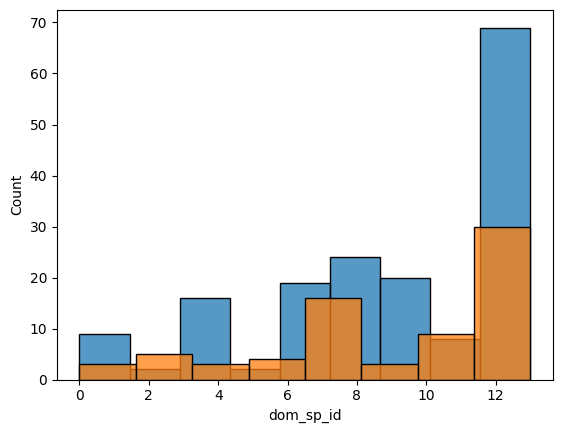

In [188]:
# Compare the distribution of dominant species in the training and test sets
sns.histplot(train_df['dom_sp_id'])
sns.histplot(test_df['dom_sp_id'])



In [191]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=25)

rf.fit(train_df[features_ls], train_df['dom_sp_id'])

# Apply the model to the test set
test_df['pred_dom_sp_id'] = rf.predict(test_df[features_ls])

# Calculate accuracy and kappa
from sklearn.metrics import accuracy_score, cohen_kappa_score

accuracy = accuracy_score(test_df['dom_sp_id'], test_df['pred_dom_sp_id'])
kappa = cohen_kappa_score(test_df['dom_sp_id'], test_df['pred_dom_sp_id'])

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.51


<Axes: >

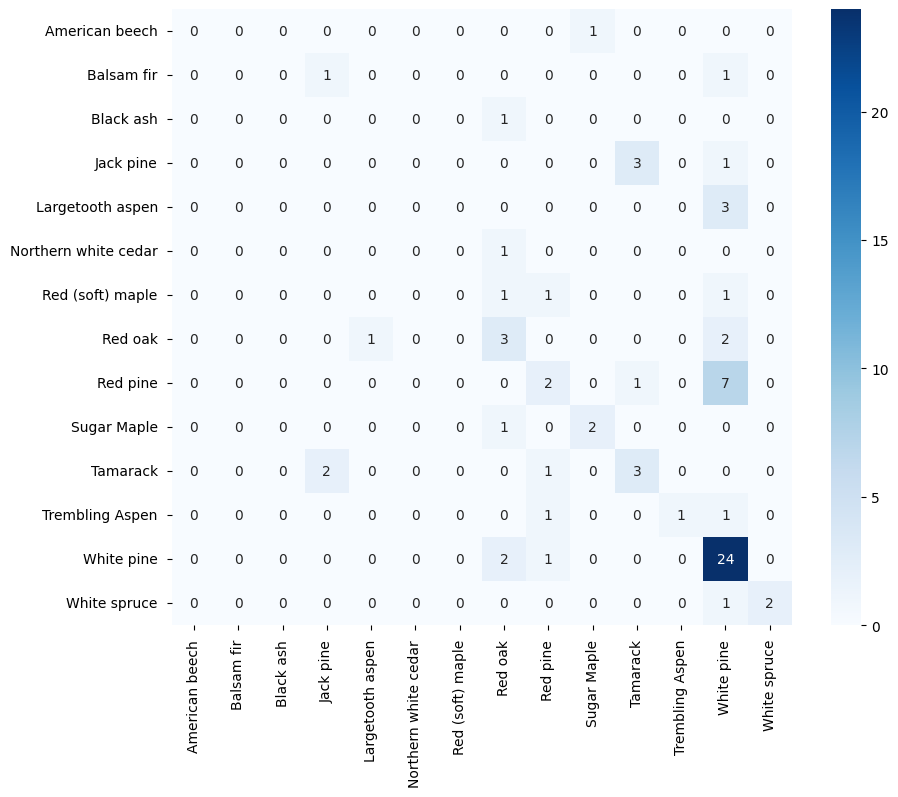

In [192]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_df['dom_sp_id'], test_df['pred_dom_sp_id'])
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=dom_sp_dict.values(), 
            yticklabels=dom_sp_dict.values())

# Add feature selection using a method from SKlearn:

https://scikit-learn.org/stable/modules/feature_selection.html
